In [1]:
import numpy as np
import matplotlib.pyplot as plt

from estimator.soc_ekf import SOCWithEKF
from sox.battery.ecm.model import Thevenin
from sox.battery.ecm.default.inputs import default_inputs
import sox.battery.protocol as protocol

# Thevenin Model Use Case

In [2]:
ecm = Thevenin(default_inputs)

In [3]:
experiments = [
    # constant current then constant voltage charge, then rest
    protocol.cc_charge_cv_rest(c_rate=2.0, cv_hold_c_rate_limit=1 / 6, rest_time_h=0.1),
    # constant current discharge, then rest
    protocol.cc_discharge_rest(),
    # constant current charge and discharge cycling
    protocol.charge_discharge_cycling(direction="charge", number_of_cycles=3),
    # constant current discharge pulse, then rest
    protocol.single_pulse(direction="discharge", c_rate=2.0, pulse_time_sec=60, pulse_rest_time_sec=60),
    # one type of constant current discharge pulses back-to-back, with rest in between
    protocol.single_pulse_train(direction="discharge", number_of_pulses=20),
    # two types of constant current discharge pulses back-to-back, with rest in between
    protocol.multi_pulse_train(
        direction=["discharge", "discharge"],
        c_rate=[1.0, 0.2],
        pulse_time_sec=[60, 600],
        pulse_rest_time_sec=[600, 600],
        number_of_pulses=10,
    ),
    # three types of constant current charge and discharge pulses back-to-back, with rest in between
    protocol.multi_pulse_train(
        direction=["discharge", "charge", "discharge"],
        c_rate=[1.0, 1.0, 0.2],
        pulse_time_sec=[60, 60, 600],
        pulse_rest_time_sec=[600, 600, 600],
        number_of_pulses=10,
    ),
    # DST (dynamic stress test) protocol
    protocol.dst_schedule(
        peak_power=3.8 * (6 * 10),
        number_of_cycles=10,
        sampling_time_s=1,
    ),
]

# simulates the experiments
solutions = [ecm.solve(experiment) for experiment in experiments]

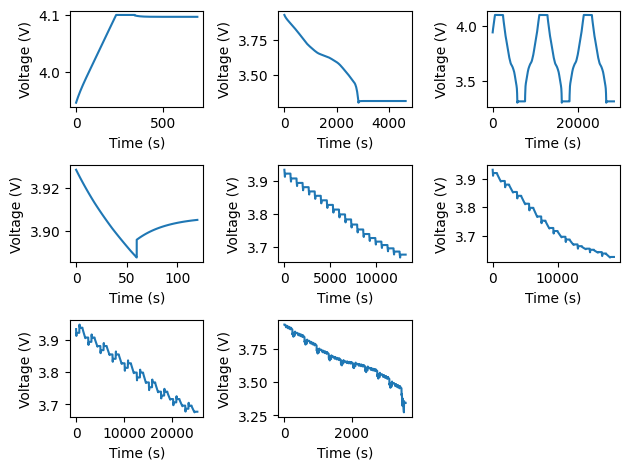

In [7]:
# plots the results

plt.figure()
for i, solution in enumerate(solutions):
    plt.subplot(3, 3, i + 1)
    plt.plot(solution.time, solution.voltage)
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (V)")
plt.tight_layout()
plt.show()

# State Estimation

In [3]:
from sox.sensor.sensor import Sensor
from sox.sensor.noise import Normal
from sox.sensor.fault import Offset, Scaling, Drift, StuckAt
from sox.filter.coulomb_count import CoulombCount
from sox.filter.extended_kalman_filter import ExtendedKalmanFilter

dt = 1.0
solution = ecm.solve(protocol.charge_discharge_cycling(number_of_cycles=3, sampling_time_s=dt))

time = solution.time
voltage = solution.voltage
current = solution.current
soc = solution.soc
cell_temperature = solution.cell_temperature

In [6]:
# sets up the sensors

voltage_sensor = Sensor(
    name="voltage sensor",
    time=time,
    data=voltage,
    noise=Normal(0, 0.002),
    faults=[
        Offset(activation_probability=0.001, random_seed=2345, offset=-0.1),
        Scaling(start_time=1000, stop_time=1500, scale=0.99),
        StuckAt(start_time=2000, stop_time=2500, value=3.0),
    ],
)
current_sensor = Sensor(
    name="current sensor",
    time=time,
    data=current,
    noise=Normal(0, 0.1),
    faults=[
        StuckAt(start_time=500, stop_time=600, value=0.0),
    ],
)
temperature_sensor = Sensor(
    name="temperature sensor",
    time=time,
    data=cell_temperature,
    noise=Normal(0, 0.1),
    faults=[
        Drift(start_time=0, stop_time=np.inf, rate=0.1 / 3600),
    ],
)


# sets up the coulomb counter

soc_with_coulomb_count = CoulombCount(
    initial_soc=default_inputs.initial_soc, capacity=default_inputs.capacity, sampling_time=1.0
)


# sets up the extended kalman filter

rc_pairs = 1
initial_soc = 0.9
ocv_func = default_inputs.open_circuit_voltage
r0 = 4.5e-4  # solution.series_resistance
r1 = 6e-4  # solution.rc_resistance[0]
c1 = 5e4  # solution.rc_capacitance[0]
capacity = 10

a1 = np.exp(-dt / (r1 * c1))
F = np.diag([1.0, a1])  # state transition matrix
B = np.array([-dt / capacity / 3600, r1 * (1 - a1)])[:, np.newaxis]  # input matrix

x0 = np.array([initial_soc, 0.0])[:, np.newaxis]  # initial states [soc, v_rc1]
P0 = np.diag([0.005, 0.0255])  # initial covariance of states
Q = np.diag([1e-6, 1e-5])  # process noise
R = np.array([[1e-6]])  # measurement noise

ekf = ExtendedKalmanFilter(F, B, Q, R, x0, P0)  # x_bar=Fx+Bu, z=Hx
soc_with_ekf = SOCWithEKF(ocv_func, rc_pairs)


# runs the state estimation

v_sense = []
i_sense = []
t_sense = []
soc_cc = []
soc_ekf = []
try:
    while True:
        # sensor readings
        voltage_reading = voltage_sensor.read()
        current_reading = current_sensor.read()
        temperature_reading = temperature_sensor.read()

        # coulomb counting
        soc_with_coulomb_count.update(current_reading)

        # extended kalman filter
        ekf.predict(u=np.array([[current_reading]]))
        ekf.update(
            z=voltage_reading,
            HJacobian=soc_with_ekf.measurement_jacobian,
            Hx=soc_with_ekf.measurement,
            hj_args=(),
            hx_args=(r0, current_reading),
        )

        # store states and sensor readings
        soc_cc.append(soc_with_coulomb_count.soc)
        soc_ekf.append(ekf.x[0, 0])
        v_sense.append(voltage_reading)
        i_sense.append(current_reading)
        t_sense.append(temperature_reading)
except IndexError as e:
    print(e)

Data streaming finished. No more data available from the sensor


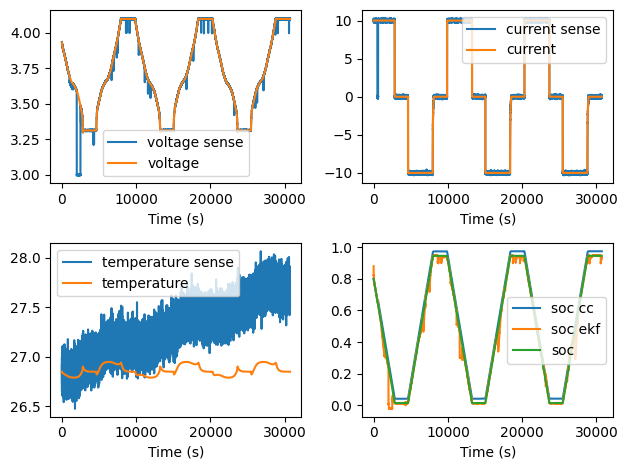

In [11]:
plt.figure()
plt.subplot(2, 2, 1)
plt.plot(time, v_sense, label="voltage sense")
plt.plot(time, voltage, label="voltage")
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(time, i_sense, label="current sense")
plt.plot(time, current, label="current")
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(time, t_sense, label="temperature sense")
plt.plot(time, cell_temperature, label="temperature")
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(time, soc_cc, label="soc cc")
plt.plot(time, soc_ekf, label="soc ekf")
plt.plot(time, soc, label="soc")
for ax in plt.gcf().axes:
    ax.set_xlabel("Time (s)")
plt.legend()
plt.tight_layout()
plt.show()